In [1]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

#### Let's load the Nashville zipcode data and look at the first few rows
- geopandas reads files with the `read_file()` method
- The zipcode data was downloaded from https://data.nashville.gov/General-Government/Zip-Codes/u7r5-bpku

In [2]:
zipcodes = gpd.read_file('../data/zipcodes.geojson')
print(zipcodes.crs)
zipcodes.head( )

epsg:4326


,zip,objectid,po_name,shape_stlength,shape_starea,geometry
0,37115,1,MADISON,178783.02488886821,596553400.57885742,"MULTIPOLYGON (((-86.68725 36.31821, -86.68722 ..."
1,37216,3,NASHVILLE,75820.997821400058,188884682.28344727,"MULTIPOLYGON (((-86.73451 36.23774, -86.73425 ..."
2,37204,9,NASHVILLE,93180.292250425613,200664795.51708984,"MULTIPOLYGON (((-86.77914 36.13424, -86.77923 ..."
3,37027,11,BRENTWOOD,159760.6942933173,174978422.04101562,"MULTIPOLYGON (((-86.81258 36.06319, -86.81263 ..."
4,37064,18,FRANKLIN,28995.828320601937,46969608.005737305,"MULTIPOLYGON (((-87.02197 36.01200, -87.02140 ..."


In [3]:
type(zipcodes)

geopandas.geodataframe.GeoDataFrame

#### Note that _if_ the crs contains init it needs to be [updated](https://geopandas.org/projections.html) as shown in the cell below

In [4]:
# zipcodes.geometry.to_crs('EPSG:4326')
# print(zipcodes.crs)

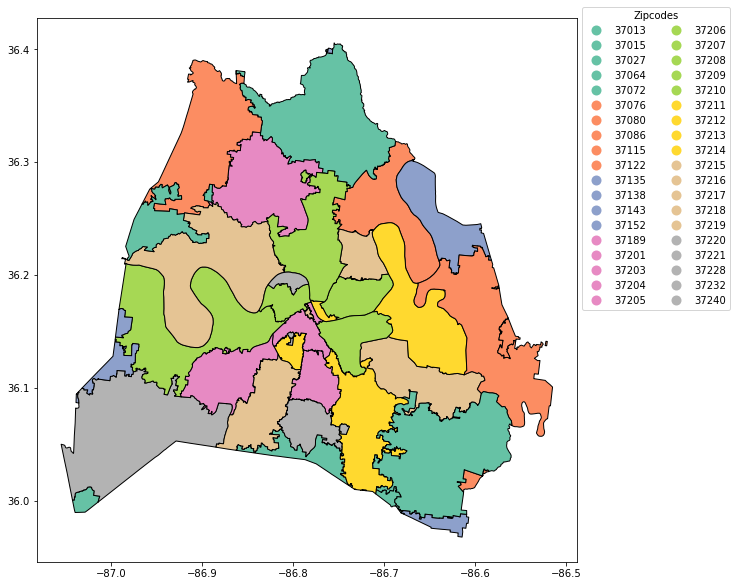

In [17]:
#geopandas handles legend styling if you pass a dict of keywords

leg_kwds = {'title': 'Zipcodes', 'loc': 'upper left', 
            'bbox_to_anchor': (1, 1.03), 'ncol': 2}
zipcodes.plot(column = 'zip', figsize=(10, 10),
              edgecolor = 'black',
              legend = True, legend_kwds = leg_kwds, 
              cmap = 'Set2')
plt.show()

#### Next you will read in the historical markers data
- downloaded from https://data.nashville.gov/History/Historical-Markers/vk65-u7my
- print the shape 
- take a look at the first 3 rows

In [5]:
historical_markers = pd.read_csv('../data/Historical_Markers.csv')
print(historical_markers.shape)
historical_markers.head(3)

(220, 11)


,Number,Year Erected,Marker Name,Marker Text,Civil War Site?,Notes,Location,Latitude,Longitude,Condition,Mapped Location
0,6,1968.0,Battle of Nashville Stewart's Line,"Loring's division of Stewart's Corps, Hood's C...",True,NaN,4618 Lealand Lane,36.086311,-86.791167,NaN,POINT (-86.791167 36.086311)
1,90,1992.0,University School of Nashville,Founded in 1915 as the successor to The Winthr...,NaN,NaN,2000 Edgehill Avenue,36.143990,-86.798228,NaN,POINT (-86.798228 36.14399)
2,168,2018.0,May-granbery House and Alford Cemetery,Revolutionary War Pvt. John Alford built a two...,NaN,Council District 4,621 Hill Road,36.047802,-86.754991,NaN,POINT (-86.754991 36.047802)


In [6]:
historical_markers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Number           220 non-null    int64  
 1   Year Erected     215 non-null    float64
 2   Marker Name      220 non-null    object 
 3   Marker Text      220 non-null    object 
 4   Civil War Site?  11 non-null     object 
 5   Notes            110 non-null    object 
 6   Location         218 non-null    object 
 7   Latitude         216 non-null    float64
 8   Longitude        216 non-null    float64
 9   Condition        18 non-null     object 
 10  Mapped Location  216 non-null    object 
dtypes: float64(3), int64(1), object(7)
memory usage: 19.0+ KB


#### In order to spatially join the bus stops with the zipcodes, you will need to create a GeoDataFrame of bus stops
- First create a geometry column that is a `Point` datatype

In [7]:
#putting x.lng, x.lat together makes them a tuple

historical_markers['geometry'] = historical_markers.apply(lambda x: Point((x.Longitude, 
                                                         x.Latitude)), 
                                        axis=1)
historical_markers.head(3)

,Number,Year Erected,Marker Name,Marker Text,Civil War Site?,Notes,Location,Latitude,Longitude,Condition,Mapped Location,geometry
0,6,1968.0,Battle of Nashville Stewart's Line,"Loring's division of Stewart's Corps, Hood's C...",True,NaN,4618 Lealand Lane,36.086311,-86.791167,NaN,POINT (-86.791167 36.086311),POINT (-86.791167 36.086311)
1,90,1992.0,University School of Nashville,Founded in 1915 as the successor to The Winthr...,NaN,NaN,2000 Edgehill Avenue,36.143990,-86.798228,NaN,POINT (-86.798228 36.14399),POINT (-86.79822799999999 36.14399)
2,168,2018.0,May-granbery House and Alford Cemetery,Revolutionary War Pvt. John Alford built a two...,NaN,Council District 4,621 Hill Road,36.047802,-86.754991,NaN,POINT (-86.754991 36.047802),POINT (-86.754991 36.047802)


In [8]:
historical_markers = historical_markers.drop(['Mapped Location'], axis=1)
historical_markers.head()

,Number,Year Erected,Marker Name,Marker Text,Civil War Site?,Notes,Location,Latitude,Longitude,Condition,geometry
0,6,1968.0,Battle of Nashville Stewart's Line,"Loring's division of Stewart's Corps, Hood's C...",True,NaN,4618 Lealand Lane,36.086311,-86.791167,NaN,POINT (-86.791167 36.086311)
1,90,1992.0,University School of Nashville,Founded in 1915 as the successor to The Winthr...,NaN,NaN,2000 Edgehill Avenue,36.143990,-86.798228,NaN,POINT (-86.79822799999999 36.14399)
2,168,2018.0,May-granbery House and Alford Cemetery,Revolutionary War Pvt. John Alford built a two...,NaN,Council District 4,621 Hill Road,36.047802,-86.754991,NaN,POINT (-86.754991 36.047802)
3,19,1969.0,Meharry Medical College,"Meharry Medical College, established in 1876 t...",NaN,replaced 2012,"Meharry Medical College, D.B. Todd Boulvard en...",36.166770,-86.805937,NaN,POINT (-86.805937 36.16677)
4,29,1970.0,Madison College,Madison College was founded in 1904 as Nashvil...,NaN,NaN,"Hospital Drive off of Neely's Bend Road, Madison",36.250539,-86.683834,NaN,POINT (-86.683834 36.250539)


#### We can use the geometry field to build a GeoDataFrame 
- you want the CRS for the historical markers to match the CRS in the zipcodes GeoDataFrame 

In [9]:
zipcodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### The `GeoDataFrame()` constructor needs 3 parameters:
 - a DataFrame
 - a coordinate reference system
 - a geometry

In [11]:
hm_geo = gpd.GeoDataFrame(historical_markers, 
                           crs = zipcodes.crs, 
                           geometry = historical_markers['geometry'])

In [12]:
type(hm_geo)

geopandas.geodataframe.GeoDataFrame

#### Now you are ready to combine historical markers and zipcodes with a spatial join
- first a little clean up for the zipcodes
    - just keep the zip, po_name, and geometry columns
- then construct the join 
    - keep in mind that you want to find the bus stops within a zip code polygon
    - the geometry for the new (combined) GeoDataFrame comes from the left GeoDataFrame

In [13]:
zipcodes = zipcodes[['zip', 'po_name', 'geometry']]

In [14]:
#find historical markers within zipcodes
#sjoin = spatial join
hms_by_zip = gpd.sjoin(hm_geo, zipcodes, op = 'within')

In [15]:
hms_by_zip.head()

,Number,Year Erected,Marker Name,Marker Text,Civil War Site?,Notes,Location,Latitude,Longitude,Condition,geometry,index_right,zip,po_name
0,6,1968.0,Battle of Nashville Stewart's Line,"Loring's division of Stewart's Corps, Hood's C...",True,NaN,4618 Lealand Lane,36.086311,-86.791167,NaN,POINT (-86.79117 36.08631),53,37220,NASHVILLE
14,132,2008.0,Dry-stack Stone Walls,"Dry-stack stone walls, a Scots-Irish building ...",True,NaN,4708 Granny White Pike,36.085384,-86.804379,NaN,POINT (-86.80438 36.08538),53,37220,NASHVILLE
117,134,2008.0,"Battle of Nashville (december 16, 1864) Confed...",After the withdrawal from the main Confederate...,True,NaN,827 Tyne Blvd,36.077687,-86.777135,NaN,POINT (-86.77714 36.07769),53,37220,NASHVILLE
148,205,2019.0,Crieve Hall,The Crieve Hall neighborhood was part of the o...,NaN,Council District 26,498 Hogan Road,36.065264,-86.757741,NaN,POINT (-86.75774 36.06526),53,37220,NASHVILLE
181,28,1970.0,Granny White Grave,Lucinda 'Granny' White of N.C. acquired 50 acr...,NaN,Marker Project- prioirty list replaced with up...,Travelers Ridge Drive off of Granny White Pike,36.073301,-86.807104,NaN,POINT (-86.80710 36.07330),53,37220,NASHVILLE


#### Now that the data is joined spatially you can count the historical markers by zip code and see how many are within each polygon 
- using the `value_counts()` method

In [16]:
hms_by_zip['zip'].value_counts()

37203    42
37212    15
37208    14
37209    12
37205    11
37201    11
37206    11
37210    10
37221     8
37215     8
37204     7
37211     7
37217     6
37214     6
37013     6
37218     5
37220     5
37207     5
37115     4
37219     4
37138     4
37228     3
37076     3
37216     2
37213     2
37080     1
37027     1
37072     1
37189     1
Name: zip, dtype: int64

#### Let's take a closer look at the 42 historical markers in the 37203 zip code
- filter the hms_by_zip data to just get bus stops in 37203
- filter the zip code geodataframe to just the polygon (row) for 37203

In [31]:
hms_in_37203 = hms_by_zip.loc[hms_by_zip['zip'] == '37203']
hms_in_37203.shape

(42, 14)

In [32]:
polygon37203 = zipcodes.loc[zipcodes['zip'] == '37203']
polygon37203.shape

(1, 3)

#### Now plot these two together
- first plot the polygon for 37203 and make it light green
- next plot the points for the historical markers and color them by year erected

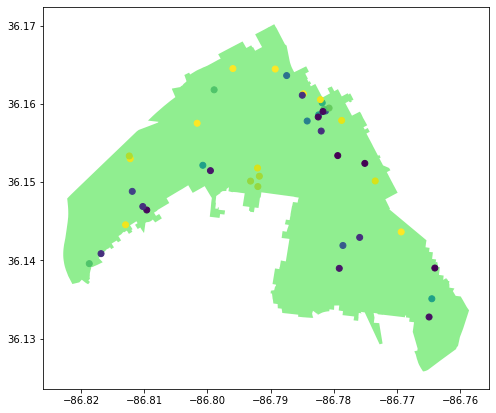

In [33]:
#fig, ax = matplotlib.subplots()
ax = polygon37203.plot(figsize = (8, 10), color = 'lightgreen')
#ax = ax plots the points on top of the polygon
hms_in_37203.plot( ax = ax, column = 'Year Erected');
plt.show();

#### folium maps require a center point for the street map. 
- Make use of a GeoSeries attribute (.centroid) which gives the center of a polygon

In [34]:
#warning is safe to ignore - just saying we should reproject our crs
polygon37203.geometry.centroid

/var/folders/kz/f2x26zgj2q5_y3k46h56qkw80000gn/T/ipykernel_15235/1338320488.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygon37203.geometry.centroid


35    POINT (-86.78899 36.14860)
dtype: geometry

In [35]:
#find the center of the polygon and look at it
center = polygon37203.geometry.centroid[35]
print(center)

POINT (-86.78898899667411 36.14860232841574)


/var/folders/kz/f2x26zgj2q5_y3k46h56qkw80000gn/T/ipykernel_15235/1002089336.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = polygon37203.geometry.centroid[35]


#### Folium requires a location point as an array 
- with *latitude* first
- but shapely Points have *longitude* first 

In [36]:
# reverse the order when constructing the array for folium location
area_center = [center.y, center.x]

# check the order of area_center, the location for our folium map
print(area_center)

[36.14860232841574, -86.7889889966741]


#### To create a folium map just call the folium `Map()` constructor
- `location` is the only argument required by the constructor
    - Set `area_center` as the `location` of the folium map. 
- `zoom_start` is an optional argument 
    - A setting of 12 should get us nice and close

In [37]:
#create our map of Nashville Zip Code 37203 and show it
map_37203 = folium.Map(location =  area_center, zoom_start = 12)
map_37203

#### Next, let's add our 37203 polygon and historical markers.
#### `itterows()` is a generator that iterates through the rows of a DataFrame and returns a tuple with the row id and row values. 
- Below, we are printing the row values for the first 3 row as we iterate through the GeoDataFrame of historical markers in 37203. 
- This idea will be helpful for creating our markers!

In [38]:
i = 0
for row_index, row_values in hms_in_37203.iterrows():
    if i <3: 
        print('index is', row_index)
        print('values are:')
        print(' ')
        print(row_values)
        print('------------------------- ')
        i+=1

index is 20
values are:
 
Number                                                           186
Year Erected                                                  2019.0
Marker Name                         Nashville Porter and Ale Brewery
Marker Text        In 1815, T.M. Burland opened a small brewery 1...
Civil War Site?                                                  NaN
Notes                                 donated by Scott Mertie family
Location                                         1901 Charlotte Ave.
Latitude                                                   36.157522
Longitude                                                 -86.801631
Condition                                                        NaN
geometry                                POINT (-86.801631 36.157522)
index_right                                                       35
zip                                                            37203
po_name                                                    NASHVILLE
Name: 20

#### Create map_37203 again with additional features:
- add the zipcode area outline (polygon37203)
- iterate through the hms_in_37203 to
    - create location from each lat and lng
    - create a popup from the stop column
    - create a custom icon if you want with [font-awesome](https://fontawesome.com/v4.7.0/icons/)
    - build a marker from each location and popup and (optionally) your custom icon 
    - add the marker to  `map_37203`
- display `map_37203`

In [43]:
#draw our zip code area: 37203
map_37203 = folium.Map(location =  area_center, zoom_start = 12)

folium.GeoJson(polygon37203).add_to(map_37203)

#iterate through stops_in_37203 to create locations and markers 
#for each bus stop
#remember for Folium locations, lat is listed first!!

for row_index, row_values in hms_in_37203.iterrows():
    loc = [row_values['Latitude'], row_values['Longitude']]
    pop = str(row_values['Marker Name'])
    icon=folium.Icon(color="darkred",icon="map-marker", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop, icon = icon) 

    marker.add_to(map_37203)
map_37203.save('../maps/map37203.html')

#display our map
map_37203

#### If you have a lot of markers, you might want to use marker clusters
- Folium has `MarkerCluster()` and `FastMarkerCluster()`
- Construct a `MarkerCluster()` 
    - construct a `MarkerCluster()` and `.add_to()` the map
    - when you loop through the data and create markers add those to the marker cluster
- Construct a `FastMarkerCluster()` by passing a list of locations

#### You can save your map as an html file and it will retain the interactive qualities

In [44]:
cluster_map_37203 = folium.Map(location =  area_center, zoom_start = 12)

#create a marker cluster
marker_cluster = MarkerCluster().add_to(cluster_map_37203)

folium.GeoJson(polygon37203).add_to(cluster_map_37203)

# inside the loop add each marker to the cluster
#prefix='fa' tells it to pull in something from fontawesome
for row_index, row_values in hms_in_37203.iterrows():
    loc = [row_values['Latitude'], row_values['Longitude']]
    pop = str(row_values['Marker Name'])
    icon=folium.Icon(color="darkred",icon="map-marker", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop,
    icon = icon) 
    
    marker.add_to(marker_cluster)

    
#save an interactive HTML map by calling .save()
cluster_map_37203.save('../maps/cluster37203.html')

cluster_map_37203  

In [45]:
#draw our zip code area: 37203
map_37203 = folium.Map(location =  area_center, zoom_start = 12)

folium.GeoJson(polygon37203).add_to(map_37203)

#create a list of locations and pass them to FastMarkerCluster()
locations = hms_in_37203[['Latitude', 'Longitude']].values.tolist()
map_37203.add_child(
    FastMarkerCluster(locations)
)



#display our map
map_37203